In [96]:
import numpy as np
import scipy
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [64]:
df = pd.read_csv('C:/Users/Han/Desktop/Box Sync/Stat 485/Final Project/cleaned.data.csv', index_col=[0])

<ipython-input-64-30203b14c1a0>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/Han/Desktop/Box Sync/Stat 485/Final Project/cleaned.data.csv', index_col=[0])


Change loan_approved to 1 or 0 and move it to the last column

In [65]:
label = df['loan_approved']
df = df.drop(['loan_approved'], axis =1)
df.insert(loc=23, column = 'loan_approved', value = label)

In [66]:
df.loan_approved= df.loan_approved.astype(str).map({'No':0, 'Yes':1})

Drop redundant columns, county_name, county_code, denials

In [67]:
df = df.drop(['county_name','county_code','denials'], axis = 1)

Drop column: hoepa_status_name, because it is perfectly in line with the approval of the loan

In [69]:
df = df.drop(['hoepa_status_name'], axis = 1)

Process label encoder on the object variables to work with sk.classifier

In [70]:
df.dtypes

tract_to_msamd_income             float64
population                          int64
minority_population               float64
number_of_owner_occupied_units      int64
number_of_1_to_4_family_units       int64
loan_amount_000s                    int64
hud_median_family_income            int64
applicant_income_000s               int64
property_type_name                 object
owner_occupancy_name               object
loan_type_name                     object
loan_purpose_name                  object
lien_status_name                   object
co_applicant_sex_name              object
census_tract_number               float64
applicant_sex_name                 object
agency_abbr                        object
applicant_race                     object
co_applicant_race                  object
loan_approved                       int64
dtype: object

In [71]:
le = preprocessing.LabelEncoder()
for column_name in df.columns:
    if df[column_name].dtype == object:
        df[column_name] = le.fit_transform(df[column_name])
    else:
        pass

Adjust a few column's dtype

In [72]:
#df.loc[:,'property_type_name':'loan_approved'] = df.loc[:,'property_type_name':'loan_approved'].apply(pd.Categorical)

List the # of copies of each class

In [73]:
df.loan_approved.value_counts()

1    251758
0     60016
Name: loan_approved, dtype: int64

Prepare the Y/label and the X

In [74]:
y = df.loan_approved

In [75]:
x = df.drop('loan_approved', axis =1)

In [76]:
x.dtypes

tract_to_msamd_income             float64
population                          int64
minority_population               float64
number_of_owner_occupied_units      int64
number_of_1_to_4_family_units       int64
loan_amount_000s                    int64
hud_median_family_income            int64
applicant_income_000s               int64
property_type_name                  int32
owner_occupancy_name                int32
loan_type_name                      int32
loan_purpose_name                   int32
lien_status_name                    int32
co_applicant_sex_name               int32
census_tract_number               float64
applicant_sex_name                  int32
agency_abbr                         int32
applicant_race                      int32
co_applicant_race                   int32
dtype: object

In [77]:
x.head()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,property_type_name,owner_occupancy_name,loan_type_name,loan_purpose_name,lien_status_name,co_applicant_sex_name,census_tract_number,applicant_sex_name,agency_abbr,applicant_race,co_applicant_race
1,121.690002,8381,23.790001,2175,2660,227,73300,116,1,2,0,2,1,2,413.27,0,0,5,5
2,83.370003,4915,23.990000,1268,1777,240,57900,42,1,2,1,1,1,3,9208.01,2,3,4,7
3,91.129997,5075,11.820000,1136,1838,241,73300,117,1,2,0,2,1,0,414.00,2,3,8,9
4,146.169998,5032,8.590000,1525,1820,351,73300,315,1,2,0,2,1,0,405.10,2,4,5,5
5,162.470001,5183,10.500000,1705,2104,417,78100,114,1,2,0,0,1,2,907.00,0,1,8,9


Split

In [78]:
seed = 127
xtrain,xtest, ytrain, ytest = train_test_split(x,y,test_size =.2, random_state= seed)

Let do some un-tuned prediction and use them as the baseline performance

In [79]:
rfc = RandomForestClassifier() # examplify
rfc = rfc.fit(xtrain,ytrain) # use the class' fit

result = rfc.score(xtest,ytest) # get the score/accuracy with no tuning to see some preliminary results
result

0.8199823590730495

We can try to print all trees out, although there is definitely no need

In [80]:
#print('All tree: %s' %r fc.estimators_)

We can also print out all predictions' probabilities

In [81]:
print('Every predition being 1 with probability of: %s' % rfc.predict_proba(xtest)[:,1]) # if we change the index 1 to 0, we get the proba of prediction being 0

Every predition being 1 with probability of: [0.91 0.91 0.98 ... 0.54 0.59 0.72]


Check on the ROC AUC

In [82]:
roc_auc_score(ytest, rfc.predict_proba(xtest)[:,1])

0.739205521290503

In [83]:
print('The importance of each feature: %s' % rfc.feature_importances_)

The importance of each feature: [0.06916899 0.06550009 0.06992751 0.06429345 0.06507239 0.17136774
 0.02572272 0.18815675 0.0055981  0.01038367 0.01979556 0.04669747
 0.00633593 0.01707433 0.0693325  0.02280041 0.03504209 0.02888765
 0.01884263]


Feature Ranking
 1) applicant_income_000s          0.188157
 2) loan_amount_000s               0.171368
 3) minority_population            0.069928
 4) census_tract_number            0.069333
 5) tract_to_msamd_income          0.069169
 6) population                     0.065500
 7) number_of_1_to_4_family_units  0.065072
 8) number_of_owner_occupied_units 0.064293
 9) loan_purpose_name              0.046697
10) agency_abbr                    0.035042
11) applicant_race                 0.028888
12) hud_median_family_income       0.025723
13) applicant_sex_name             0.022800
14) loan_type_name                 0.019796
15) co_applicant_race              0.018843
16) co_applicant_sex_name          0.017074
17) owner_occupancy_name           0.010384
18) lien_status_name               0.006336
19) property_type_name             0.005598


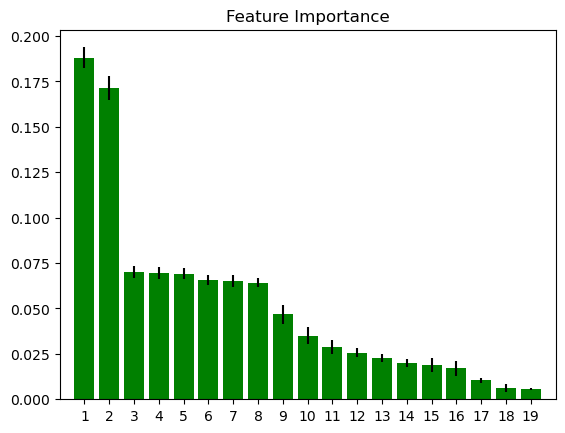

In [84]:
importances = rfc.feature_importances_ # feature's import
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis = 0)
indices = np.argsort(importances)[::-1] # Print out the feature importance ranking, -1 is to indicator ascending
print("Feature Ranking")
for f in range(xtrain.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, xtrain.columns[indices[f]], importances[indices[f]]))
plt.figure()
plt.title("Feature Importance")
plt.bar(range(xtrain.shape[1]), importances[indices], color = 'green', yerr = std[indices], align = 'center')
plt.xticks(range(xtrain.shape[1]), range(1,xtrain.shape[1]+1))
plt.xlim([-1, xtrain.shape[1]])
plt.show()

ROC curve

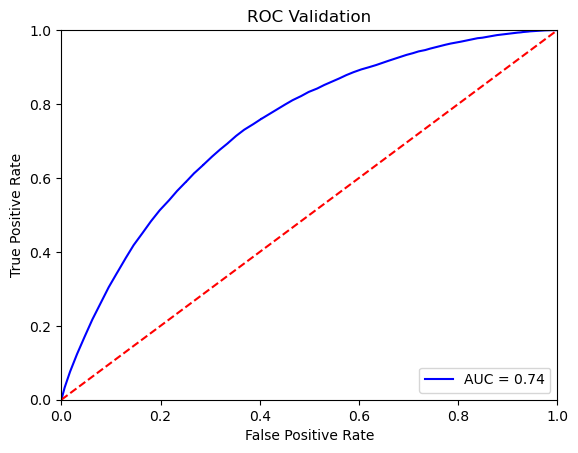

In [87]:
predictions_validation = rfc.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, predictions_validation)
roc_auc = auc(fpr, tpr)
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Next, we do CV to tune hyper-para. But first, we run a CART with 5-fold CV to see the accuracy result

In [93]:
clf = DecisionTreeClassifier(max_depth = None, min_samples_split= 2, random_state=127)
scores = cross_val_score(clf, xtrain, ytrain, cv=10, n_jobs=5)
print('CART has a mean accuracy of %0.4f after 10-fold CV' % scores.mean())

CART has a mean accuracy 0.74 after 10-fold CV


## Then we run 5-fold CV on RF

In [95]:
clf = RandomForestClassifier(n_estimators= 200, max_depth = None, min_samples_split=2, random_state=127)
scores = cross_val_score(clf, xtrain, ytrain, cv=10, n_jobs=5)
print('RF has a mean accuracy of %0.4f after 10-fold CV' % scores.mean())

RF has a mean accuracy of 0.8174 after 10-fold CV


### The hyper parameters that need to be tuned are: n_estimators(# of trees), min_samples_split (min # of samples required to split an internal node), min_samples_leaf(min # of samples required to be at a leaf node), max_depth, max_sample (proportion of the training samples given to each tree, max = 1, this will speed up if we can lower it),  max_features (max of features given to each tree, default is square.root of d. Conventialy , the ideal number is just around the default), criterion ('gini' or 'entropy'), class_weight (None or 'balanced')

### Do a Random serach first

In [97]:
np.linspace(10, 110, num = 11)

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.])

In [101]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4, 8, 12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [4, 8, 12], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 127)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 200, scoring='roc_auc', 
                              cv = 5, verbose=2, random_state=127, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(xtrain, ytrain);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
